In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/real-estate-goldmine-dubai-uae-rental-market/dubai_properties.csv


In [3]:
data_set = pd.read_csv("/kaggle/input/real-estate-goldmine-dubai-uae-rental-market/dubai_properties.csv")

In [30]:
for attr in data_set.columns:
    if len(data_set[attr]) != len(data_set[data_set[attr].notnull()]):
        print("there are null values:"+attr)
    else:
        print("no missing value:"+attr)

#Tek missing valuelar olan attributelar coğrafi attributelar

no missing value on Address
no missing value on Rent
no missing value on Beds
no missing value on Baths
no missing value on Type
no missing value on Area_in_sqft
no missing value on Rent_per_sqft
no missing value on Rent_category
no missing value on Frequency
no missing value on Furnishing
no missing value on Purpose
no missing value on Posted_date
no missing value on Age_of_listing_in_days
no missing value on Location
no missing value on City
no missing value on Latitude
no missing value on Longitude


In [ ]:
print(len(data['Longitude']) , len(data[data['Longitude'].notnull()]))
#Baya bir şey değiştiriyor coğrafi data bu nedenle bence direkt onları yok saymak mantıklı

In [4]:
#Missing value olan instancelar direkt silinir.
data_set = data_set.dropna(subset=["Latitude"])
data_set = data_set.dropna(subset=["Longitude"])
data_set = data_set.reset_index(drop=True) 
data = data_set.copy()

In [ ]:
data_set.describe()

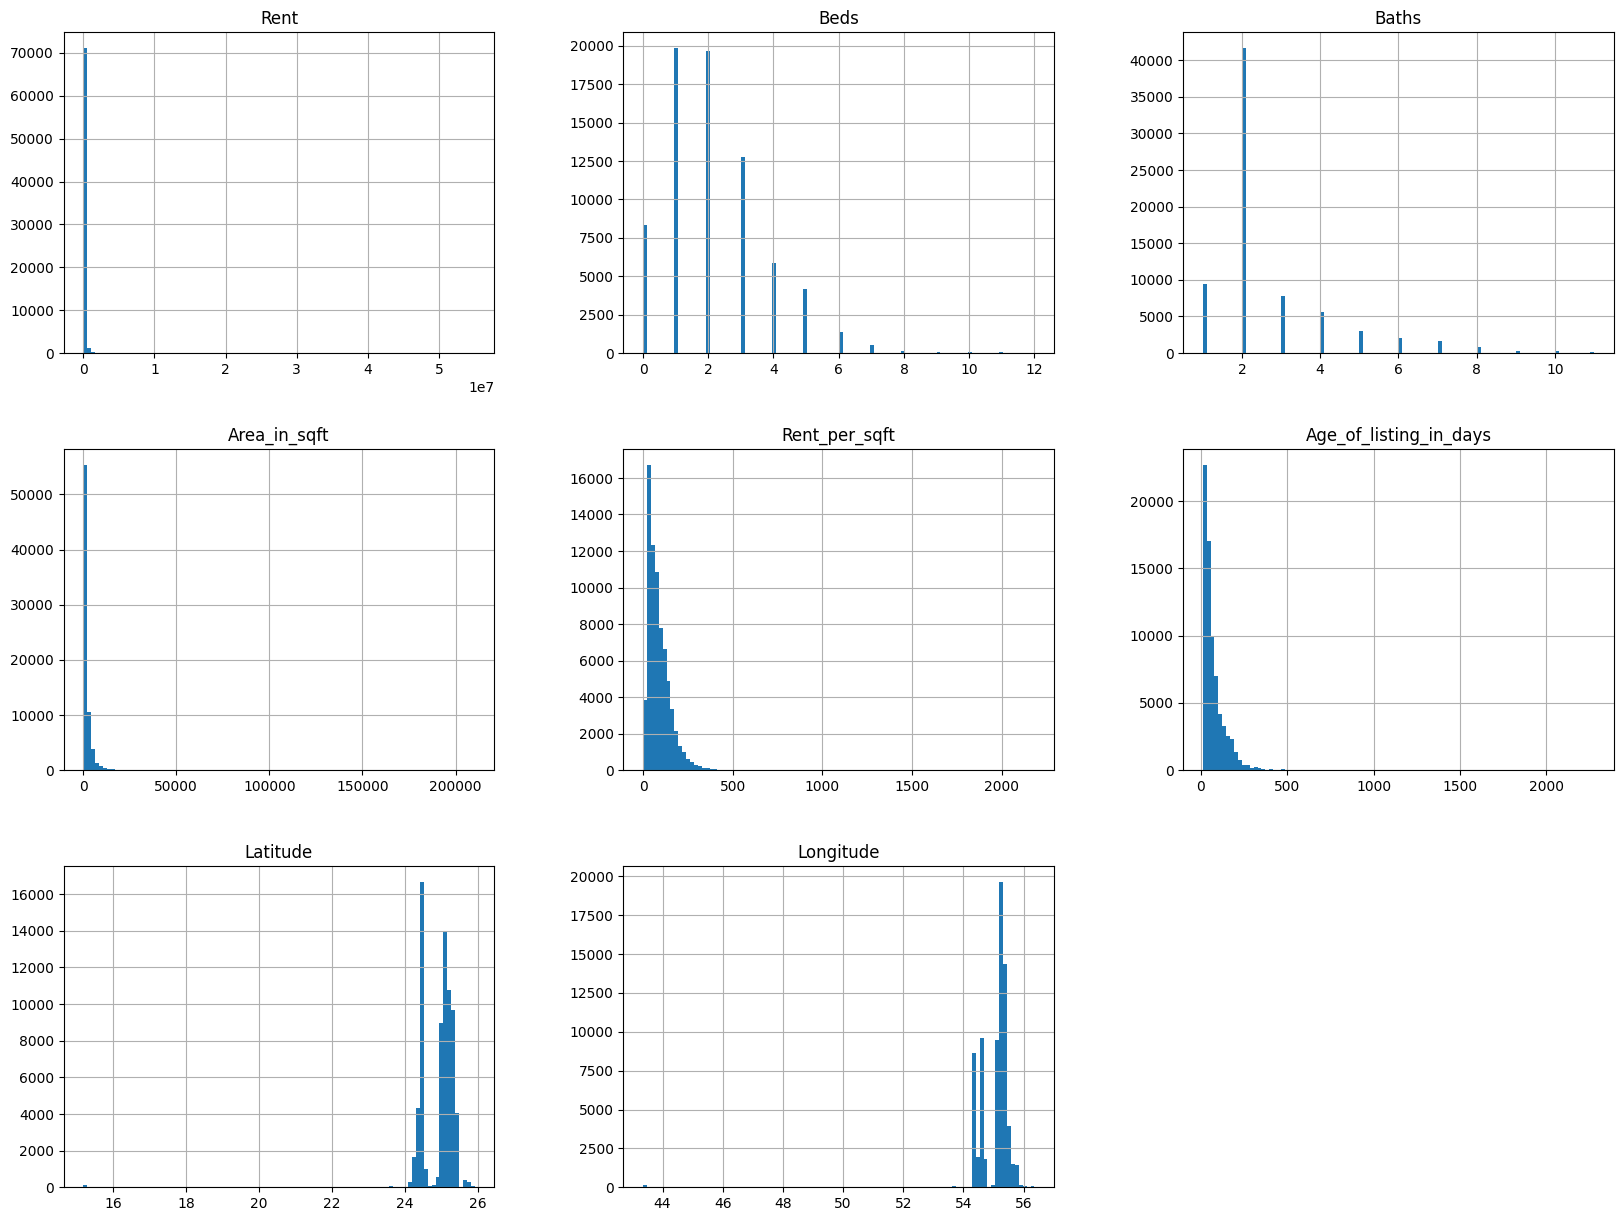

In [5]:

data_set.hist(bins=100,figsize=(20,15))
plt.show()

In [28]:
#data['bed_and_baths'] = data['Baths'] + data['Beds'] toplamak da lineer olarak bağlantısız
data['bed_per_baths'] = data['Beds'] / data['Baths'] #corr = 0.37 değerli bir veri.
#data['years_listing'] = data['Age_of_listing_in_days'] / 360bir şeyi değiştirmez  

In [29]:
corr_matrix = data.corr(numeric_only=True)
corr_matrix['Rent'].sort_values(ascending=False)

Rent                      1.000000
Area_in_sqft              0.410185
bed_per_baths             0.373375
Rent_per_sqft             0.348614
Beds                      0.311179
Baths                     0.080013
Latitude                  0.027837
Longitude                 0.007521
Age_of_listing_in_days    0.002431
Name: Rent, dtype: float64

<Axes: xlabel='Longitude', ylabel='Latitude'>

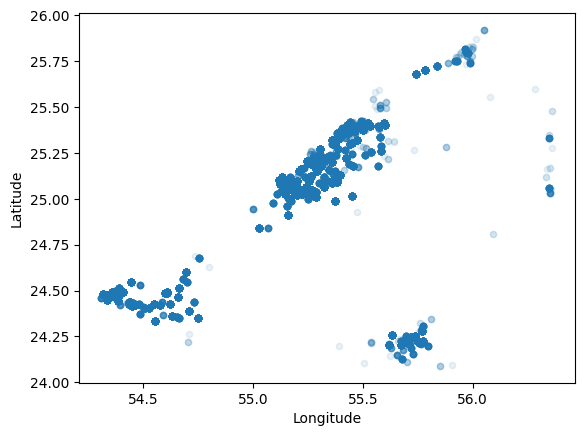

In [36]:
data[data['Longitude']>54].plot(kind='scatter',x='Longitude',y='Latitude',alpha = 0.1)

In [9]:
#Gereksiz columnlar droplanır.
data = data.drop(['Frequency','Purpose','Posted_date','Address'],axis=1)

In [ ]:
data.head()

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit # Stratified bir data split yapılmış olunur.

#Stratified bir split alınır. Analizi daha zor olsa da daha doğru bir yaklaşımdır.
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["Rent_category"]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]

# labellar alınır.
data_labels_train = strat_train_set["Rent"].copy()
data_labels_test = strat_test_set["Rent"].copy()

#saf train datası tutulur.
data_train = strat_train_set.drop(["Rent","Rent_category"], axis=1)
data_test = strat_test_set.drop(["Rent","Rent_category"], axis=1)

In [29]:
data_train.head()

,Beds,Baths,Type,Area_in_sqft,Rent_per_sqft,Furnishing,Age_of_listing_in_days,Location,City,Latitude,Longitude,bed_per_baths
12855,2,3,Apartment,1750,46.856571,Unfurnished,73,Al Khalidiyah,Abu Dhabi,24.469344,54.348806,0.666667
16750,0,1,Apartment,650,84.615385,Unfurnished,124,Yas Island,Abu Dhabi,24.494022,54.607372,0.000000
56785,0,2,Apartment,500,120.000000,Unfurnished,15,Al Jaddaf,Dubai,25.214294,55.324569,0.000000
70685,1,2,Apartment,1500,22.000000,Furnished,15,Al Qasimia,Sharjah,25.345655,55.397058,0.500000
62495,3,4,Apartment,1618,132.879481,Furnished,194,Dubai Creek Harbour,Dubai,25.197978,55.360380,0.750000


In [11]:
#numeric attributelar için bir pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([
('std_scaler', StandardScaler()),
])

In [12]:
data_num = data_train.drop(['Furnishing','City','Location','Type'],axis=1)

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
num_attribs = list(data_num)
cat_attribs = ['Furnishing','City','Location','Type']
full_pipeline = ColumnTransformer([
("num", num_pipeline, num_attribs),
("cat", OneHotEncoder(), cat_attribs),
])
data_prepared = full_pipeline.fit_transform(data_train)

In [ ]:
data_prepared.plot(kind="scatter", x="Longitude", y="Latitude",alpha = 0.1
            ,label="rent",figsize = (10,7),c = "Rent",
              cmap=plt.get_cmap("jet"), colorbar=True
)

In [18]:
#Lineer regresyon
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()

lin_reg.fit(data_prepared, data_labels_train)

LinearRegression()

In [31]:
some_data = data_test.iloc[:10]
some_labels = data_labels_test.iloc[:10]

some_data_prepared = full_pipeline.transform(some_data)
#Lineer regresyonun testleri.
print("Predictions:", lin_reg.predict(some_data_prepared))

print("Labels:", list(some_labels))

Predictions: [ 94009.3081948   77438.2916726   98120.74206992  13717.62002842
 177068.25943768 -18015.99585106 293764.80054384 554710.07307909
 202005.68709686 243528.89110151]
Labels: [155000, 37999, 120000, 85000, 215000, 25000, 115000, 410000, 170000, 219999]


Belli ki lineer regresyon iyi bir seçim değil..

In [15]:
from sklearn.neural_network import MLPRegressor

regr = MLPRegressor(random_state=1,activation='relu',solver='adam',hidden_layer_sizes = (25,5), max_iter=500)

regr.fit(data_prepared, data_labels_train)

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=(25, 5), max_iter=500, random_state=1)

In [26]:
#Burada k-fold cross validation yapmak lazım son olarak. Onu sonradan yapıcam.
print("Predictions:", regr.predict(some_data_prepared))

print("Labels:", list(some_labels))

print("Score",regr.score(some_data_prepared, some_labels))

Predictions: [ 1.53479231e+05  3.60934300e+04  7.87748224e+04  9.14882418e+04
  2.12942012e+05  2.34382424e+04  1.61633882e+05  4.34068977e+05
  1.68215029e+05  2.24330986e+05  1.59285708e+04  1.59223067e+05
  1.83276486e+05  6.55532203e+04  8.89107984e+04  6.01995652e+04
  1.57132818e+05  4.75407953e+04  3.00709060e+04  1.46976725e+05
  1.16332307e+05  5.96907086e+04  1.21722892e+05  4.16369422e+04
  1.30607635e+05  1.32370926e+05  8.17191734e+04  4.08007998e+04
  1.33237883e+05  3.47479397e+05  1.60881506e+05  1.36768827e+05
  2.26987271e+04  1.07362153e+05  2.66901286e+05  1.22863839e+05
  6.77846589e+04  7.20444532e+04  1.49622219e+05  3.45786894e+04
  1.74393308e+05  1.85617311e+05  9.67608904e+04  4.76137618e+04
  1.32482683e+05  3.49145292e+04  4.41340954e+04  4.09255313e+04
  3.42042529e+04  6.15470755e+04  1.76941377e+04  4.07228432e+04
  5.94667197e+04  4.53954323e+05  3.52157258e+04  3.43983187e+04
  3.47307900e+04  4.83765194e+02  6.92965852e+04  4.93376226e+03
  3.84624161